In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt


# **Importing Dataset**

In [64]:
#importing the dataset
from google.colab import drive
drive.mount("/content/drive")

wine_red = pd.read_csv("/content/drive/MyDrive/winequality-red.csv", sep=",", skipinitialspace=True, engine='python')
wine_white = pd.read_csv("/content/drive/MyDrive/winequality-white.csv", sep=",", skipinitialspace=True, engine='python')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Data Pre-processing**
- Merging Winequality_white and wine_quality_red data samples
- Updating the class label (Quality) to a binary class
- Spliting the train and test sample in a ratio of 8:2

In [65]:
#concatinating both data sets

data_list = [wine_red,wine_white]
df = pd.concat(data_list)
# making the index values continuous after concatenation
df = df.reset_index()
df = df.drop('index', axis=1)
#print (df)
print (df.shape)

(6497, 12)


In [66]:
# processing the dataset - the target column needs to be separated into 2 classes
### Class 0: for quality < 7
### Class 1: for quality >= 7

for i, rows in df.iterrows():
    if df.at[i,'quality'] < 7:
        df.at[i,'quality'] = 0
    else:
        df.at[i,'quality'] = 1


# separating features and target column
X = df.drop('quality', axis=1)
y = df.quality

X = X.to_numpy()
y = y.to_numpy()

print (X, y)

[[ 7.4   0.7   0.   ...  3.51  0.56  9.4 ]
 [ 7.8   0.88  0.   ...  3.2   0.68  9.8 ]
 [ 7.8   0.76  0.04 ...  3.26  0.65  9.8 ]
 ...
 [ 6.5   0.24  0.19 ...  2.99  0.46  9.4 ]
 [ 5.5   0.29  0.3  ...  3.34  0.38 12.8 ]
 [ 6.    0.21  0.38 ...  3.26  0.32 11.8 ]] [0 0 0 ... 0 1 0]


In [67]:
# class 0 and class 1 division
print (np.bincount(y))

[5220 1277]


In [68]:
## spliting data into train and test

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state= 30)

print (np.bincount(y_train), np.bincount(y_test))
#print (X_train.shape)

[4164 1033] [1056  244]


# **Defining the functions**
- Entropy
- Information Gain
- Choosing the split function and split point


In [69]:
## entropy function - for calculating the subset's entropy

def entropy(y):
  entropy = 0
  no_of_occurences = np.bincount(y) # returns a list of counts of unique values
  #print (y)
  for i in no_of_occurences:
    if i > 0:
      prob = i/len(y)
      entropy += ((-1)*prob*(np.log2(prob)))
  return entropy

print(entropy(y_train))

0.7194582877151645


In [72]:
#defining the function for calculating information gain

def information_gain(column_data,y,threshold, entropy_gini):
  #information gain = entropy(parent)-{(weighted average)*Entropy(subclass)}
  #information gain = gini_index(parent)-{(weighted average)*gini_index(subclass)}
  left_idxs = np.zeros(len(column_data))
  right_idxs = np.zeros(len(column_data))

  left_idxs = np.array(left_idxs, dtype='bool')
  right_idxs = np.array(right_idxs, dtype='bool')

  for i in range(len(column_data)):
    if column_data[i]<threshold:
      left_idxs[i] = True
      right_idxs[i] = False
    else:
      left_idxs[i] = False
      right_idxs[i] = True


  #handling the case where all samples belong to the same class - Information gain in such case = 0
  if np.all(left_idxs) or np.all(right_idxs):
    return 0

  left_y = y[left_idxs]
  right_y = y[right_idxs]

  if entropy_gini == 0:
    parent_entropy = entropy(y)
    weight_avg = (len(left_y) / len(y)) * entropy(left_y) + (len(right_y) / len(y)) * entropy(right_y)
    information_gain = parent_entropy - weight_avg

  elif entropy_gini == 1:
    parent_gini_impurity = gini_impurity(y)
    weight_avg = (len(left_y) / len(y)) * gini_impurity(left_y) + (len(right_y) / len(y)) * gini_impurity(right_y)
    information_gain = parent_gini_impurity - weight_avg


  return information_gain



In [73]:
#finding the column to split on: the one with maximum information gain
## and the value at which splitting takes place

def splitting_criteria(X, y, column_list, entropy_gini):
  max_gain = -1
  threshold, feature = None, None
  for i in column_list:
    #print(i)
    column_data = X[:,i]
    distinct_column_values = np.unique(column_data)
    for j in distinct_column_values:
      info_gain = information_gain(column_data, y, j, entropy_gini)
      if info_gain > max_gain:
        max_gain = info_gain
        threshold = j
        feature = i
  return feature, threshold

# **Creating a tree node**

In [74]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None,*,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

In [263]:
print (X.shape)

(6497, 11)


# **Building the Decision tree**

In [81]:
class DecisionTree:
    #initializing the class
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None, entropy_gini = 0):
        self.min_samples_split=min_samples_split
        self.max_depth=max_depth
        self.n_features=n_features # no. of features to be considered while checking the best split
        self.root=None
        ## keeping this variable for deciding whether to use entropy or gini_impurity
        ### entropy_gini == 0, implies use entropy.
        ### entropy_gini == 1, implies use gini impurity
        ## By default it will take entropy
        self.entropy_gini = entropy_gini

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1],self.n_features)
        self.root = self.growth(X, y)
        return self.root

    def growth(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # check the stopping criteria - leaf node
        if (depth>=self.max_depth or n_samples<self.min_samples_split):
            leaf_value = np.bincount(y).argmax()
            return Node(value=leaf_value)

        #getting a list of shuffled feature indexes
        feature_indexes = np.random.choice(n_feats, self.n_features, replace=False)

        # Find the feature and the threshold value to split the node. Using a single threshold as it is a binary tree
        splitting_column, splitting_thresh = splitting_criteria(X, y, feature_indexes, self.entropy_gini)

        # generating a list of row indexes which will fall under left and right children
        splitting_column_data = X[:,splitting_column]
        l_indices = np.zeros(len(splitting_column_data))
        r_indices = np.zeros(len(splitting_column_data))

        l_indices = np.array(l_indices, dtype='bool')
        r_indices = np.array(r_indices, dtype='bool')

        for i in range(len(splitting_column_data)):
          l_indices[i] = splitting_column_data[i]<splitting_thresh
          r_indices[i] = splitting_column_data[i]>=splitting_thresh


        # If all elements belong to the same class, then need not split
        ## make it a leaf
        if np.all(l_indices) or np.all(r_indices):
            leaf_value = np.bincount(y).argmax()
            return Node(value=leaf_value)

        # Create left and right child nodes
        left = self.growth(X[l_indices], y[l_indices], depth + 1)
        right = self.growth(X[r_indices], y[r_indices], depth + 1)
        return Node(splitting_column, splitting_thresh, left, right)




# **Prediction function**

In [76]:
# creating the function to predict class labels of test samples
def predict(X, root):
  return np.array([tree_traversal(x, root) for x in X])

def tree_traversal(x, node):
  if node.is_leaf_node():
    return node.value
  elif x[node.feature] <= node.threshold:
    return tree_traversal(x, node.left)
  else:
    return tree_traversal(x, node.right)

# **Training the Decision tree**

In [88]:
dt = DecisionTree(max_depth=10) #max-depth can be changed to get a better accuracy
root_node = dt.fit(X_train, y_train)


# **Testing the model on the testing dataset**

In [89]:
y_predicted = predict(X_test, root_node)

In [90]:
# Getting the accuracy

def accuracy_function(y_test, y_pred):
  sum = 0
  for i in range(len(y_test)):
    if y_test[i]==y_pred[i]:
      sum += 1
  return sum/len(y_test)

acc = accuracy_function(y_test, y_predicted)
print("Accuracy:", acc)


Accuracy: 0.7984615384615384


In [20]:
row_indexes = np.arange(start=0, stop =len(y_test), step =1)
# print (row_indexes)
# print (y_test)

[   0    1    2 ... 1297 1298 1299]
[0 0 0 ... 0 0 0]


# **Visualization**
- Confusion matrix
- Scatter plot

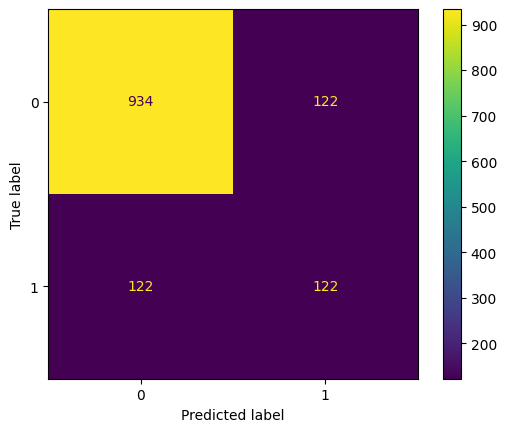

In [21]:
# Printing the confusion matrix
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, y_predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

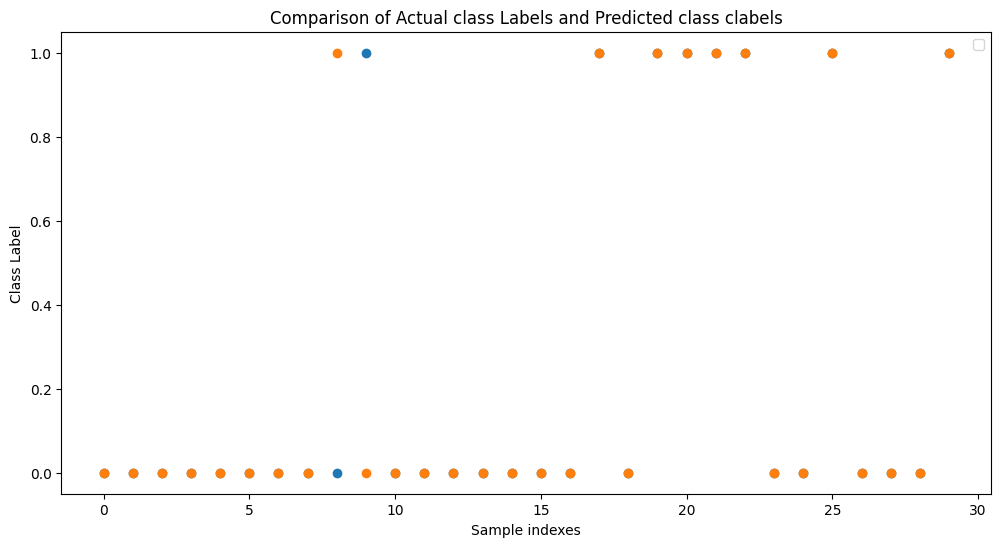

In [22]:
#plotting a scatter plot - predicted class label and actual class label

#plotting i points for better visualization
i = 30

# Plotting y_train and predictions
plt.figure(figsize=(12, 6))

# Plot training labels
##Actual class labels
plt.scatter(row_indexes[:i], y_test[:i])
##Predicted class labels
plt.scatter(row_indexes[:i], y_predicted[:i])

plt.xlabel('Sample indexes')
plt.ylabel('Class Label')
plt.title('Comparison of Actual class Labels and Predicted class clabels')
plt.legend()
plt.show()

# **K fold cross validation : with k=10**

In [91]:
# splitting the entire data set into 10 parts randomly

y_train = y_train.reshape(-1, 1)
data = np.concatenate((X_train, y_train), axis=1)
y_train = y_train.flatten()
#print (data.shape)

#splitting the dataset
size_of_fold = data.shape[0]//10
last_fold_size = size_of_fold + data.shape[0]%10
#print ((size_of_fold*9)+(last_fold_size), df.shape[0])

folds = []
for i in range(0,data.shape[0],size_of_fold):
  folds.append(data[i:i+size_of_fold])  # 11 folds created, last fold with the remainder 7 elements

folds[9] = np.concatenate((folds[9],folds[10]), axis=0)
del folds[10]
# print (len(folds))
# for i in range(len(folds)):
#   print (folds[i].shape)
# print(size_of_fold,last_fold_size)

In [98]:
#making the k-fold validation function
def k_fold(train_data, test_data):
  train_X = train_data[:, :-1]
  train_y = (train_data[:, -1]).astype(int)

  test_X = test_data[:, :-1]
  test_y = (test_data[:, -1]).astype(int)

  dt = DecisionTree(max_depth=5) #defualt case will use entropy
  root_node = dt.fit(train_X, train_y)

  y_predicted = predict(test_X, root_node)

  accuracy_value = accuracy_function(test_y, y_predicted)
  return accuracy_value


In [99]:
#executing the K fold cross validation and storing the accuracies in an array

accuracy_k_fold = []

#keeping 9 folds for training and 1 fold for testing and calling the k-fold validation function
for i in range(len(folds)):
  test_data = folds[i]
  temp = []
  for j in range(len(folds)):
    if j!=i:
      temp.append(folds[j])
  train_data = temp[0]
  for j in range(1,len(temp)):
    train_data = np.concatenate((train_data,folds[j]), axis=0)

  #print(train_data)

  #calling the k-fold validation function
  accuracy_value = k_fold(train_data, test_data)
  accuracy_k_fold.append(accuracy_value)

print (accuracy_k_fold)

[0.8516377649325626, 0.8362235067437379, 0.8246628131021194, 0.8208092485549133, 0.8285163776493256, 0.8111753371868978, 0.8458574181117534, 0.8342967244701349, 0.8265895953757225, 0.8231939163498099]


In [97]:
#Calculating average accuracy

average_accuracy = sum(accuracy_k_fold)/len(accuracy_k_fold)
print ("Accuracy of K-fold validation:", average_accuracy)

Accuracy of K-fold validation: 0.8335820567484999


# **Improvements**
- Using Gini index as a measure instead on entropy

# **Using Gini impurity**

In [35]:
# Defining gini_impurity function
def gini_impurity(y):
  gini_index = 1
  occurence = np.bincount(y) # returns a list of counts of unique values
  #print (occurence)
  for i in occurence:
    if i > 0:
      prob = i/len(y)
      gini_index -= (prob**2)
  return gini_index

print ("parent_gini_index:", gini_impurity(y_train))

parent_gini_index: 0.3185191912757057


In [48]:
# Training the dataset using gini index

#added a parameter in the DecisionTree class
### entropy_gini == 0, implies use entropy.
### entropy_gini == 1, implies use gini impurity
## By default it will take entropy if nothing specified

dt = DecisionTree(max_depth=5, entropy_gini=1)
root_node = dt.fit(X_train, y_train)

In [49]:
#Predicting the class values
y_predicted = predict(X_test, root_node)

In [50]:
#Calculating the accuracy

accuracy_gini = accuracy_function(y_test, y_predicted)
print("Accuracy using gini_impurity:", accuracy_gini)

Accuracy using gini_impurity: 0.8246153846153846
